In [1]:
import pickle


with open("/path/to/pklFiles/store_series_dict.pkl","rb") as file:
    store_series_dict=pickle.load(file)

In [2]:
from darts.dataprocessing.transformers import  StaticCovariatesTransformer
import numpy as np
import sklearn
from darts.metrics import rmse,mae
from darts import TimeSeries, concatenate
import matplotlib.pyplot as plt

In [3]:
train_series_store = {}
val_series_store = {}
forecast_series_store = {}
test_series_store = {}
future_covs_store = {}
series_store = {}

store_static_scalers = {}


for store_id, product_series_list in store_series_dict.items():
    # Preprocess data 
    # Split into train/val (last 28 days for validation)
    train_series = []
    test_series = []
    future_covariates = []

    for target, covs in product_series_list:
        train_target = target[:-28].astype(np.float32)
  
        test_target = target[-28:].astype(np.float32)  
        forecast_target = target[:-28].astype(np.float32)
        series_target = target.astype(np.float32)

        train_series.append(train_target)
        test_series.append(test_target)
        future_covariates.append(covs.astype(np.float32))

    train_series_store[store_id] = train_series
    test_series_store[store_id] = test_series
    future_covs_store[store_id] = future_covariates

    static_scaler = StaticCovariatesTransformer(transformer_num=None, cols_num=None) #cols_cat=["item_id", "dept_id", "cat_id"])
    store_static_scalers[store_id] = static_scaler.fit(train_series)

In [4]:
from darts.models import LightGBMModel

def train_model_store(train_series,covariates_series):

    model = LightGBMModel(
    # Choose your lags (number of past timesteps to use). For example:
        lags=28,  # or range(1,29) if you want t-1 to t-28
        #lags_past_covariates=28,
        lags_future_covariates=list(range(-28,0)),
        # All LightGBM hyperparams:
        boosting_type="gbdt",
        objective="tweedie",
        tweedie_variance_power=1.1,
        metric='mse',
        n_jobs=-1,
        random_state=42,  
        learning_rate=0.2,
        bagging_fraction=0.85,
        bagging_freq=1,
        colsample_bytree=0.85,    
        colsample_bynode=0.85,   
        lambda_l1=0.5,
        lambda_l2=0.5,
        verbose = -1,
        categorical_future_covariates = [#"tm_d","tm_m","tm_y", "tm_w_end", "tm_dw", "tm_wm",
                                    "event_name_1_enc", "event_type_1_enc", "event_name_2_enc", "event_type_2_enc"],
        categorical_static_covariates= ["item_id", "dept_id", "cat_id"]
    )

    model.fit(series=train_series,
                future_covariates=covariates_series
    )
    
    return model



In [ ]:
for store_id, _ in store_series_dict.items():

    train_series = store_static_scalers[store_id].transform(train_series_store[store_id])

    model = train_model_store(train_series, future_covs_store[store_id])

    model.save(f"/path/to/BasicModels/lgbm/Store_Forecasting/store_models/model_{store_id}")

# Predicting

In [ ]:
forecast_stores_dict = {}
for store_id, _ in store_series_dict.items():
    model = LightGBMModel.load(f"/path/to/BasicModels/lgbm/Store_Forecasting/store_models/model_{store_id}")

    forecast_stores_dict[store_id] = model.predict( n=28,
                                            series=store_static_scalers[store_id].transform(train_series_store[store_id]),
                                            future_covariates=future_covs_store[store_id])

<Axes: xlabel='date'>

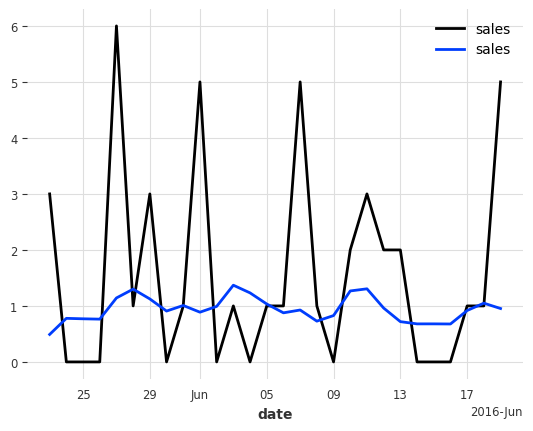

In [8]:
test_series_store['CA_1'][0].plot()
forecast_stores_dict['CA_1'][0].plot()

In [9]:
from darts.metrics import rmse,mae

rmse_dict = {}
mae_dict = {}

for store_id in store_series_dict.keys():
    rmse_dict[store_id] = rmse(store_static_scalers[store_id].transform(test_series_store[store_id]),forecast_stores_dict[store_id])
    mae_dict[store_id] = mae(store_static_scalers[store_id].transform(test_series_store[store_id]),forecast_stores_dict[store_id])

In [ ]:

for store_id in store_series_dict.keys():
    print(f"mean RMSE for store : {store_id} -> {np.mean(rmse_dict[store_id])}")
    print(f"mean MAE for store : {store_id} -> {np.mean(mae_dict[store_id])} \n")

mean RMSE for store : CA_1 -> 1.5792696679928073
mean MAE for store : CA_1 -> 1.2816999984476551 

mean RMSE for store : CA_2 -> 1.628137127500287
mean MAE for store : CA_2 -> 1.2830037765736626 

mean RMSE for store : CA_3 -> 1.9485828194469579
mean MAE for store : CA_3 -> 1.5771245515610481 

mean RMSE for store : CA_4 -> 1.1154797929869884
mean MAE for store : CA_4 -> 0.9009884957058173 

mean RMSE for store : TX_1 -> 1.2420825262999586
mean MAE for store : TX_1 -> 1.0063715070657304 

mean RMSE for store : TX_2 -> 1.380027036575422
mean MAE for store : TX_2 -> 1.1095419676868543 

mean RMSE for store : TX_3 -> 1.3928109966502062
mean MAE for store : TX_3 -> 1.1317389027433742 

mean RMSE for store : WI_1 -> 1.3251242782882553
mean MAE for store : WI_1 -> 1.0665104022474379 

mean RMSE for store : WI_2 -> 1.633914985957303
mean MAE for store : WI_2 -> 1.3281187167430528 

mean RMSE for store : WI_3 -> 1.355608698046147
mean MAE for store : WI_3 -> 1.0876767135215113 



In [12]:
# Compute the mean RMSE for each store and then average across all stores
mean_rmse_per_store = [np.mean(values) for values in rmse_dict.values()]
mean_rmse = np.mean(mean_rmse_per_store) if mean_rmse_per_store else 0

# Compute the mean MAE for each store and then average across all stores
mean_mae_per_store = [np.mean(values) for values in mae_dict.values()]
mean_mae = np.mean(mean_mae_per_store) if mean_mae_per_store else 0



print(f"Mean RMSE: {mean_rmse}")
print(f"Mean MAE: {mean_mae}")

Mean RMSE: 1.4601037929744332
Mean MAE: 1.177277503229614


# Backtest

# Testing for 'CA_2'

In [39]:
model = LightGBMModel.load(f"/path/to/BasicModels/lgbm/Store_models/model_CA_2")

results = model.backtest(
    series=store_static_scalers['CA_2'].transform(series_store['CA_2']),
    future_covariates=future_covs_store['CA_2'],
    forecast_horizon=28,
    stride=28,
    retrain=False,  # Critical - prevents model refitting
    start=0.7,
    metric=[rmse, mae],  # List of metrics to compute
    reduction=np.mean,  # Average scores (default)
    last_points_only=False,  # Use all forecast points (not just last)
    verbose=True,
    metric_kwargs={'n_jobs': -1} 
)


`enable_optimization=True` is ignored because `forecast_horizon > model.output_chunk_length`. To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


historical forecasts:   0%|          | 0/3047 [00:00<?, ?it/s]

In [41]:
rmse_list_ca2 = [r[0] for r in results ]
mae_list_ca2 = [r[1] for r in results]
print(f"Average RMSE across all series: {np.mean(rmse_list_ca2)}")
print(f"Average MAE across all series: {np.mean(mae_list_ca2)}")

Average RMSE across all series: 1.3921792865561953
Average MAE across all series: 1.107725494183991


# Backtesting in all stores

In [42]:
backtest_results = {}

for store_id in store_series_dict.keys():
    model = LightGBMModel.load(f"/path/to/BasicModels/lgbm/Store_models/model_{store_id}")

    results = model.backtest(
        series=store_static_scalers[store_id].transform(series_store[store_id]),
        future_covariates=future_covs_store[store_id],
        forecast_horizon=28,
        stride=28,
        retrain=False,  # Critical - prevents model refitting
        start=0.7,
        metric=[rmse, mae],  # List of metrics to compute
        reduction=np.mean,  # Average scores (default)
        last_points_only=False,  # Use all forecast points (not just last)
        verbose=True,
        metric_kwargs={'n_jobs': -1} 
    )
    backtest_results[store_id] = results

`enable_optimization=True` is ignored because `forecast_horizon > model.output_chunk_length`. To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


historical forecasts:   0%|          | 0/3048 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `forecast_horizon > model.output_chunk_length`. To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


historical forecasts:   0%|          | 0/3047 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `forecast_horizon > model.output_chunk_length`. To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


historical forecasts:   0%|          | 0/3046 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `forecast_horizon > model.output_chunk_length`. To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


historical forecasts:   0%|          | 0/3047 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `forecast_horizon > model.output_chunk_length`. To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


historical forecasts:   0%|          | 0/3049 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `forecast_horizon > model.output_chunk_length`. To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


historical forecasts:   0%|          | 0/3048 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `forecast_horizon > model.output_chunk_length`. To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


historical forecasts:   0%|          | 0/3049 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `forecast_horizon > model.output_chunk_length`. To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


historical forecasts:   0%|          | 0/3048 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `forecast_horizon > model.output_chunk_length`. To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


historical forecasts:   0%|          | 0/3046 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `forecast_horizon > model.output_chunk_length`. To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


historical forecasts:   0%|          | 0/3049 [00:00<?, ?it/s]

In [45]:
rmse_global_list = []
mae_global_list = []
for store_id in backtest_results.keys():
    rmse_list = [r[0] for r in backtest_results[store_id] ]
    mae_list = [r[1] for r in backtest_results[store_id]]
    rmse_mean = np.mean(rmse_list)
    mae_mean = np.mean(mae_list)

    rmse_global_list.append(rmse_mean)
    mae_global_list.append(mae_mean)

    print(f"Average RMSE for store {store_id} ->  {rmse_mean}")
    print(f"Average MAE for store {store_id} ->  {mae_mean} \n")

Average RMSE for store CA_1 ->  1.5048319295669135
Average MAE for store CA_1 ->  1.2194142875287761 

Average RMSE for store CA_2 ->  1.3921792865561953
Average MAE for store CA_2 ->  1.107725494183991 

Average RMSE for store CA_3 ->  1.8385675434306321
Average MAE for store CA_3 ->  1.4756405555848506 

Average RMSE for store CA_4 ->  1.036547094885046
Average MAE for store CA_4 ->  0.8453271232983345 

Average RMSE for store TX_1 ->  1.1881339635343866
Average MAE for store TX_1 ->  0.9652444360191983 

Average RMSE for store TX_2 ->  1.3272466835470575
Average MAE for store TX_2 ->  1.078678485757924 

Average RMSE for store TX_3 ->  1.2918039537230195
Average MAE for store TX_3 ->  1.0570386457949552 

Average RMSE for store WI_1 ->  1.267193902959915
Average MAE for store WI_1 ->  1.0240126298634729 

Average RMSE for store WI_2 ->  1.5061439566448898
Average MAE for store WI_2 ->  1.2262289696696662 

Average RMSE for store WI_3 ->  1.2334734441140054
Average MAE for store WI_3

In [46]:
print(f"Average RMSE  ->  {np.mean(rmse_global_list)}")
print(f"Average MAE   ->  {np.mean(mae_global_list)} ")

Average RMSE  ->  1.3586121758962062
Average MAE   ->  1.1006017905140664 


producing Historical forecasts


In [51]:
model = LightGBMModel.load(f"/path/to/BasicModels/lgbm/Store_models/model_CA_2")

pred_series = model.historical_forecasts(
    series=store_static_scalers[store_id].transform(series_store[store_id]),
    future_covariates=future_covs_store[store_id],
    forecast_horizon=28,
    stride=28,
    retrain=False,  # Critical - prevents model refitting
    start=val_series_store['CA_2'][0].start_time(),  # List of metrics to compute
    #reduction=np.mean,  # Average scores (default)
    last_points_only=False,  # Use all forecast points (not just last)
    verbose=True,
)


`enable_optimization=True` is ignored because `forecast_horizon > model.output_chunk_length`. To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


historical forecasts:   0%|          | 0/3049 [00:00<?, ?it/s]

In [53]:
pred_series_list = []
for series in pred_series:
    pred_series_list.append(concatenate(series))

In [66]:

def display_forecast(pred_series, ts_transformed, forecast_type, start_date=None):
    plt.figure(figsize=(8, 5))
    if start_date:
        ts_transformed = ts_transformed.drop_before(start_date)
    ts_transformed.univariate_component(0).plot(label="actual")
    pred_series.plot(label=("historic " + forecast_type + " forecasts"))
    plt.title(f"MAE: {mae(ts_transformed.univariate_component(0), pred_series)}")
    plt.legend()

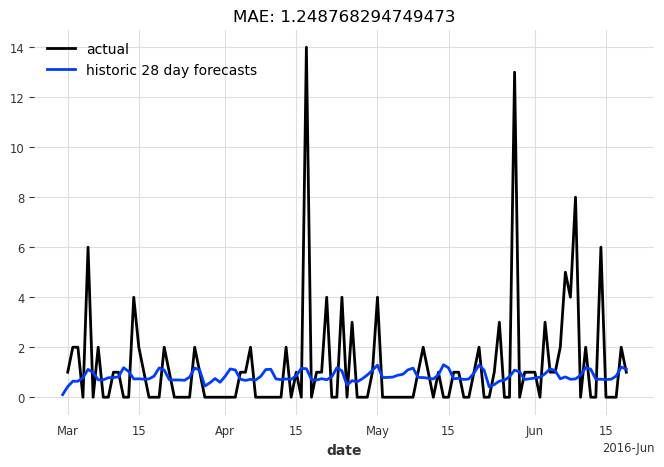

In [67]:
display_forecast(
    pred_series_list[0], series_store['CA_2'][0], "28 day", start_date=val_series_store['CA_2'][0].start_time()
)